# Reservoir computing

Here we attempt to improve the prediction of cobra solver on experimental data. The input commonly used in cobra is the concentration of compounds in the media, as an approximation of uptake fluxes of metabolism. We try here to improve the prediction of cobra here by finding a more accurate input.
First we use an AMNWt model, trained on data simulated by cobra. All weight of this model are freezed. A new model is the composition of a dense layer as input and then this model. This new model is trained on experimental dataset. The output of the trained dense layer then gives a input layer for cobra model, improving it score.

We use this idea on two pair of dataset. Fist on e_coli, we use iML1515_UB as simulated dataset and iML1515_EXP_UB as experimental dataset. Then on P.putida, we use IJN1463_10_UB as simulated dataset and IJN1463_EXP_UB_Anne.

In [1]:
# E_coli
dataset_file_simulated = "/Dataset/iML1515_UB_Anne.npz"
objective_simulated=['BIOMASS_Ec_iML1515_core_75p37M']
dataset_file_experimental = "/Dataset/iML1515_EXP_UB.npz"
objective_experimental=['BIOMASS_Ec_iML1515_core_75p37M']

model_file_simulated = "../models/AMNWt_iML1515_UB.keras"

drop_out_rate = 0

batch_size = 7
epochs = 20

## Load the pre-trained model and simulated dataset information

In [2]:
import tensorflow as tf
from amn.model.aMNWtModel import AMNWtModel, RNNCell

model_class = AMNWtModel
seed = 10
tf.random.set_seed(seed)

data_dir = "../data"


model_simulated = model_class(dataset_file=data_dir + dataset_file_simulated, 
                   objective=objective_simulated,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )


model_simulated.train_test_split(test_size=0.1, random_state=seed)

# Preprocessing
from amn.tools import MaxScaler
scaler= MaxScaler()
model_simulated.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_simulated.preprocessing_for_specific_model()


from amn.tools import custom_loss
AMNWt_model = tf.keras.models.load_model(model_file_simulated, 
                                          custom_objects={"RNNCell":RNNCell,
                                                          "my_mse":custom_loss(model_simulated.S, 
                                                                               model_simulated.P_out,
                                                                               model_simulated.P_in)}
                                          )

print("R2 :", model_simulated.R2(model_simulated.Y_train, AMNWt_model.predict(model_simulated.X_train)))
print("Q2 :", model_simulated.R2(model_simulated.Y_test, AMNWt_model.predict(model_simulated.X_test)))

number of metabolites:  1877
filtered measurements size:  1
11.0


2023-11-16 15:35:48.508931: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 15:35:48.510397: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-11-16 15:35:49.236728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


R2 : 0.9988290524957166
Q2 : 0.9990274967094778


## Load the experimental data

In [3]:
import tensorflow as tf
from amn.model import AMNWtModel


model_class = AMNWtModel
seed = 10 
# seed = 20
tf.random.set_seed(seed)


print("---------------------------------------- model ----------------------------------------")
model_experimental = model_class(dataset_file=data_dir + dataset_file_experimental, 
                   objective=objective_experimental,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )

# Preprocessing
model_experimental.train_test_split(test_size=0.1, random_state=seed)
from amn.tools import MaxScaler
scaler= MaxScaler()
model_experimental.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_experimental.preprocessing_for_specific_model()

---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
1


In [4]:
model_simulated.X.shape

(11000, 38)

## Add a layer to old pre-trained model and fix model weights

In [6]:
loss = custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in)
loss = custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in)

In [7]:

from tensorflow.keras import Model, Input, layers

input_size_exp = model_experimental.X.shape[1]
input_size_sim = model_simulated.X.shape[1]


sub_model = AMNWt_model
sub_model.trainable = False
drop_out = layers.Dropout(drop_out_rate, input_shape=(input_size_sim,))
layer = layers.Dense(input_size_sim,activation='relu')

inputs = Input((input_size_exp))
x = layer(drop_out(inputs))
y = sub_model(x)
new_model = Model(inputs=inputs, 
                  outputs=y)
new_model.compile(optimizer='adam',
              loss=loss,
              metrics=None)

In [8]:
import numpy as np
scaler= MaxScaler()

X = scaler.fit_transform(model_experimental.X)
Y = np.concatenate((model_experimental.Y, np.zeros((len(model_experimental.Y),3))), axis=1)

# Shuffle dataset
idx = np.arange(len(X))
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

In [9]:
history = new_model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=0)
pred = new_model.predict(X)
R_2 = model_simulated.R2(Y, pred)
print(R_2)

0.8054523721824849


In [11]:
pred
P_out     = tf.convert_to_tensor(np.float32(model_simulated.P_out))   
PRED = tf.linalg.matmul(pred[:,:model_simulated.S.shape[1]], tf.transpose(P_out)) 

In [12]:
TRUE = Y[:,0]
# PRED = pred
PRED = PRED - 0.03

/home/agiralt/anaconda3/envs/amn/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


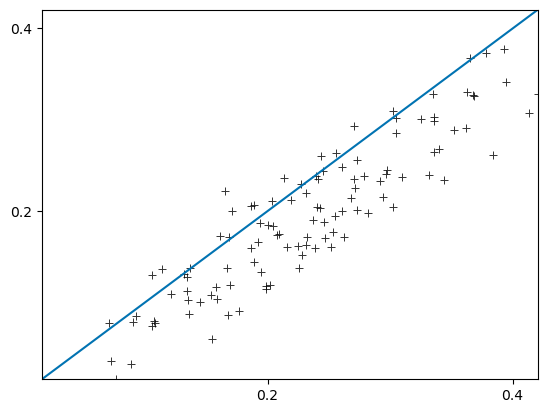

In [13]:
from amn.tools import plot_regression
plot_regression(PRED, TRUE, "", "","")

## Using cobra with output of the new_model as input on e_coli (for now)

In [14]:
# V_in is not zero
V_in = layer(X)
V_in[0]

<tf.Tensor: shape=(38,), dtype=float32, numpy=
array([0.5972636 , 0.        , 0.        , 0.        , 0.8451051 ,
       0.43571195, 0.75311387, 0.21922122, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2599421 , 0.        ,
       0.        , 0.        , 0.10244299, 1.146638  , 0.        ,
       0.        , 0.37082154, 0.        , 0.        , 0.17885995,
       1.3852212 , 0.        , 0.        , 0.        , 0.0322809 ,
       0.        , 0.3427242 , 0.        , 0.82548463, 0.        ,
       0.9644206 , 0.        , 0.68252265], dtype=float32)>

In [15]:
import cobra
from amn.run_cobra import run_cobra

# experimental
cobra_model = cobra.io.read_sbml_model(data_dir + "/Dataset/iML1515_EXP_UB.xml")
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]

# simulated
cobra_model = cobra.io.read_sbml_model(data_dir + "/Dataset/e_coli_core_UB.xml")
objective = ['BIOMASS_Ecoli_core_w_GAM']

Y_pred = []
for i in range(V_in.shape[0]):

    inf = {r.id: 0 for r in cobra_model.reactions}
    ## Reaction must be linked to e_coli_model
    for j in range(V_in.shape[1]):
        inf[model_simulated.medium[j]] = V_in[i,j]
        result = run_cobra(cobra_model,objective , inf)

    Y_pred.append(result[1])


/home/agiralt/anaconda3/envs/amn/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [16]:
TRUE = Y[:,0]
PRED = Y_pred

In [17]:
import sklearn
sklearn.metrics.r2_score(TRUE, PRED)

-7.639754955864005

In [18]:
PRED

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [19]:
TRUE

array([0.27848961, 0.22554864, 0.17652818, 0.18620895, 0.15845945,
       0.27081596, 0.20374745, 0.30990109, 0.19488304, 0.36538323,
       0.16118613, 0.13401356, 0.2020666 , 0.17060508, 0.36209367,
       0.07036642, 0.09241834, 0.26057603, 0.33618463, 0.20953583,
       0.25608325, 0.08998277, 0.23855667, 0.0765294 , 0.22754484,
       0.22768201, 0.36748529, 0.39292909, 0.29636434, 0.24690668,
       0.29771937, 0.18857016, 0.34018671, 0.37845481, 0.13622547,
       0.26096546, 0.20408691, 0.19361131, 0.24511303, 0.10738262,
       0.23097749, 0.29449714, 0.30221964, 0.10538765, 0.13398423,
       0.25188356, 0.30498805, 0.2193191 , 0.21547613, 0.24051223,
       0.33509878, 0.16876883, 0.36302645, 0.26806339, 0.10592987,
       0.38366267, 0.12092238, 0.27056665, 0.16647387, 0.16958847,
       0.19995003, 0.39489686, 0.33610419, 0.18627597, 0.16739003,
       0.30484688, 0.13505459, 0.35197431, 0.14489149, 0.19236413,
       0.27311799, 0.36883461, 0.11354416, 0.08812777, 0.26244

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


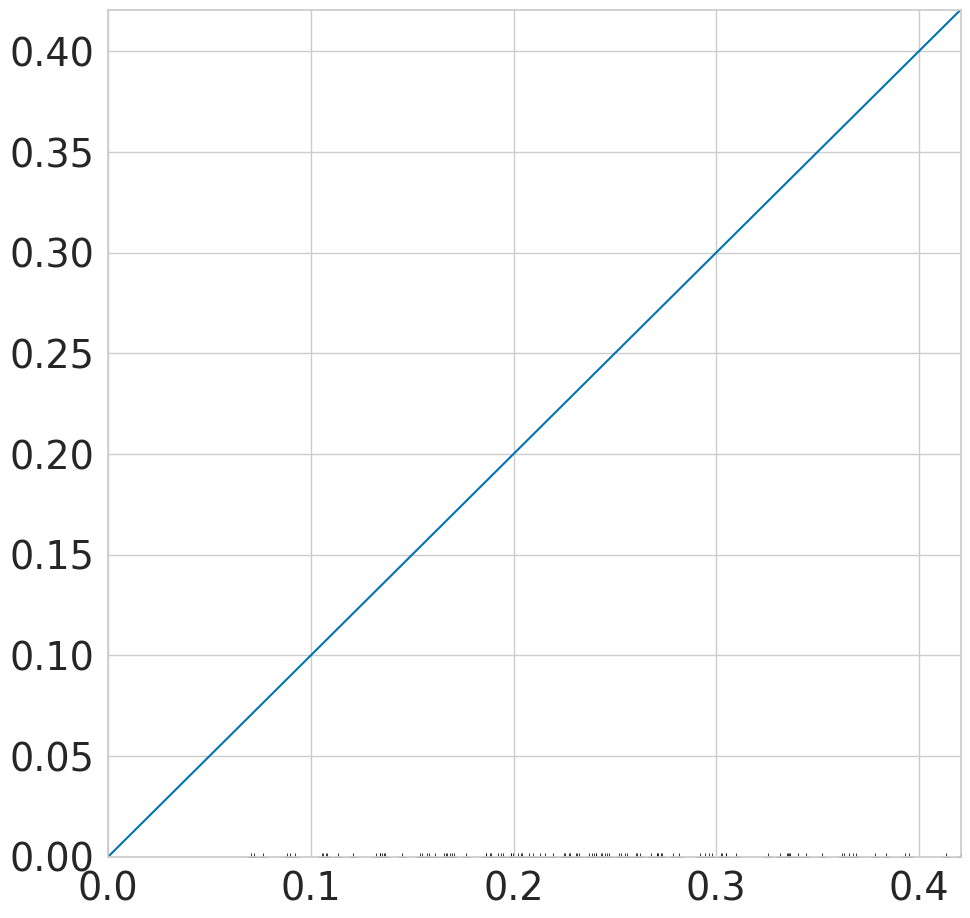

In [20]:
from amn.tools import plot_regression
plot_regression(PRED, TRUE, "", "","")